In [1]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates

In [6]:
# load data
data_path = Path('../database/i10-broadway')
X_tensor = np.load(data_path / 'training_data.npz', allow_pickle=True)['X_tensor']
X_full = pd.read_parquet(data_path / 'X_full.parquet')

# Peek shapes/types to guide later steps
print('X_tensor type:', type(X_tensor), 'shape:', getattr(X_tensor, 'shape', None))
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_tensor type: <class 'numpy.ndarray'> shape: (50, 28623, 9)
X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (1431150, 9)


In [7]:
X_full.head()

speed  travel_time_seconds  evt_duration  \
tmc_code  time_bin                                                              
115+04177 2025-06-16 00:00:00+00:00   71.0                7.500           0.0   
          2025-06-16 00:05:00+00:00   69.0                7.720           0.0   
          2025-06-16 00:10:00+00:00   70.4                7.566           0.0   
          2025-06-16 00:15:00+00:00   69.0                7.724           0.0   
          2025-06-16 00:20:00+00:00   70.2                7.588           0.0   

                                     evt_cat_major  evt_cat_minor  \
tmc_code  time_bin                                                  
115+04177 2025-06-16 00:00:00+00:00            0.0            0.0   
          2025-06-16 00:05:00+00:00            0.0            0.0   
          2025-06-16 00:10:00+00:00            0.0            0.0   
          2025-06-16 00:15:00+00:00            0.0            0.0   
          2025-06-16 00:20:00+00:00            0.0            0.0   

                                     evt_cat_closure  evt_cat_obstruction  \
tmc_code  time_bin                                                          
115+04177 2025-06-16 00:00:00+00:00              0.0                  0.0   
          2025-06-16 00:05:00+00:00              0.0                  0.0   
          2025-06-16 00:10:00+00:00              0.0                  0.0   
          2025-06-16 00:15:00+00:00              0.0                  0.0   
          2025-06-16 00:20:00+00:00              0.0                  0.0   

                                     evt_cat_misc     miles  
tmc_code  time_bin                                           
115+04177 2025-06-16 00:00:00+00:00           0.0  0.147902  
          2025-06-16 00:05:00+00:00           0.0  0.147902  
          2025-06-16 00:10:00+00:00           0.0  0.147902  
          2025-06-16 00:15:00+00:00           0.0  0.147902  
          2025-06-16 00:20:00+00:00           0.0  0.147902

In [9]:
# "flatten data" into training data X and labels y, ignore the continuity in time and space. Treat data in each time bin and each TMC as independent samples.
df_flat = X_full.reset_index()
# label
label_col = ['travel_time_seconds']
# features
feature_cols = ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc', 'miles']

X = df_flat[feature_cols]#.copy()
y = df_flat[label_col]#.copy()

# Basic NA handling: drop rows with NA in y; impute X with median
mask_valid = X.notna().all(axis=1)
X = X[mask_valid]
y = y[mask_valid]

print('Feature shape:', X.shape, '| Label shape:', y.shape)

Feature shape: (1431150, 6) | Label shape: (1431150, 1)


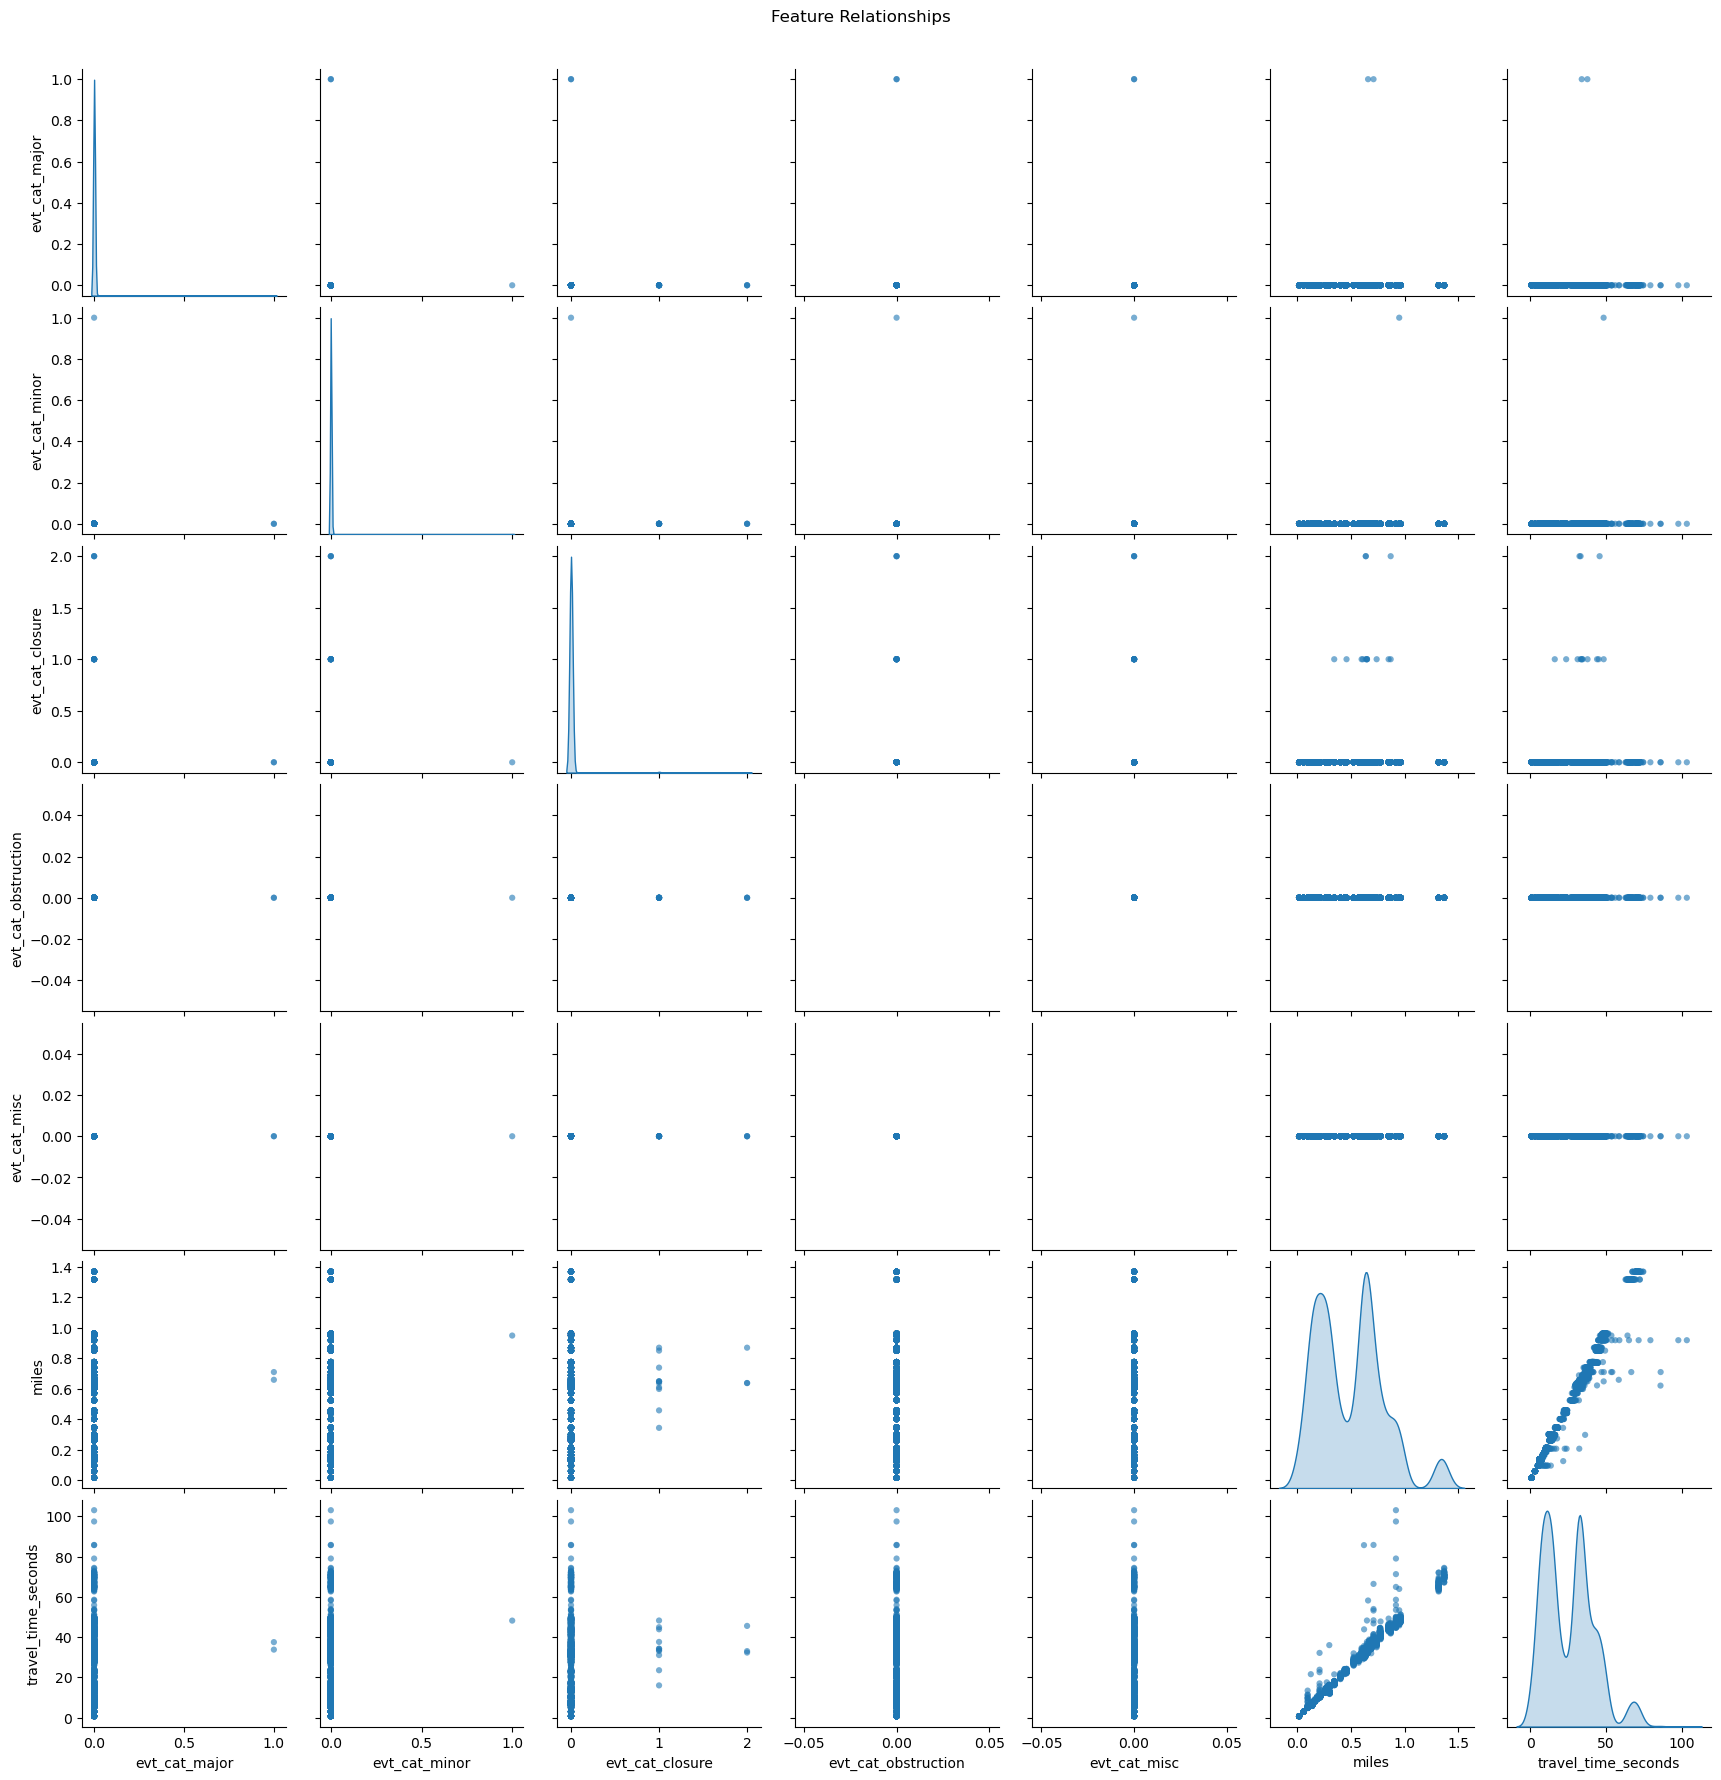

In [11]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
sample_df = df_flat.sample(n=3000, random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    # hue='any_event',
    diag_kind='kde',
    # palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [ ]:
# Split the data into training and test sets with shuffle (fix random seed for reproducibility)
from sklearn.model_selection import train_test_split

# If label looks discrete with few unique values, we could treat as classification; here we'll proceed as regression.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes: ', X_test.shape, y_test.shape)

In [ ]:
# Train a LinearRegression model with Pipeline and StandardScaler
# Report the model cross-validation error on the training set and the test set.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False is safer if any sparse-like
    ('linreg', LinearRegression())
])

# Cross-validated negative MSE on training split
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print('CV RMSE (5-fold) mean:', cv_rmse.mean(), 'std:', cv_rmse.std())

# Fit on training and evaluate on test
pipe.fit(X_train, y_train)

# Training metrics (on full training set)
y_train_pred = pipe.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

# Test metrics
y_test_pred = pipe.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print('Train RMSE:', train_rmse, '| R^2:', train_r2)
print(' Test RMSE:', test_rmse, ' | R^2:', test_r2)

In [ ]:
# Plot training and cv errors vs. model complexity (degree of polynomial features)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

max_degree = 5  # keep modest to avoid blow-up
train_rmse_list = []
cv_rmse_mean_list = []
cv_rmse_std_list = []

for deg in range(1, max_degree + 1):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('scaler', StandardScaler(with_mean=False)),
        ('linreg', LinearRegression())
    ])

    # CV on training split
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    cv_rmse_mean_list.append(cv_rmse.mean())
    cv_rmse_std_list.append(cv_rmse.std())

    # Fit and compute training error
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_rmse_list.append(train_rmse)

# Plot
degrees = np.arange(1, max_degree + 1)
plt.figure(figsize=(7, 4))
plt.plot(degrees, train_rmse_list, marker='o', label='Train RMSE')
plt.errorbar(degrees, cv_rmse_mean_list, yerr=cv_rmse_std_list, marker='s', label='CV RMSE (5-fold)')
plt.xlabel('Polynomial degree')
plt.ylabel('RMSE')
plt.title('Model complexity vs error')
plt.legend()
plt.grid(True)
plt.show()